# Customer Response Prediction

In [5]:
import pandas as pd
import numpy as np
import pickle
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from pdpbox import pdp, get_dataset, info_plots
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score 
from sklearn.model_selection import StratifiedKFold, train_test_split
from hyperopt import Trials, STATUS_OK, hp, tpe, fmin
from catboost import Pool, CatBoostClassifier

# 1. Dataset Loading and Preprocessing

In [150]:
try:
    dict_feature_types = pickle.load(open('./data/AzdiasFeatureTypeDictionary.pkl', 'rb'))
    print('Successfully loaded feature type dictionary.')
except:
    print('Feature type dictionary not found. Initialize feature types.')

Successfully loaded feature type dictionary.


In [151]:
train = pd.read_csv('./data/Udacity_MAILOUT_052018_TRAIN.csv', low_memory=False).drop(['EINGEFUEGT_AM'], axis=1)
test = pd.read_csv('./data/Udacity_MAILOUT_052018_TEST.csv', low_memory=False).drop(['EINGEFUEGT_AM'], axis=1)
customers = pd.read_csv('./data/Udacity_CUSTOMERS_052018.csv', low_memory=False).drop(['EINGEFUEGT_AM'], axis=1)

In [152]:
customers_train = customers.loc[customers.LNR.isin(train.LNR), ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']]
customers_test = customers.loc[customers.LNR.isin(test.LNR), ['PRODUCT_GROUP', 'CUSTOMER_GROUP', 'ONLINE_PURCHASE']]

In [153]:
y_train = train.RESPONSE
train = pd.concat([train.drop(['RESPONSE', 'LNR'], axis = 1).reset_index(drop=True),
                   customers_train.reset_index(drop=True)], axis=1)

lnr_test = test.LNR
test = pd.concat([test.drop(['LNR'], axis = 1).reset_index(drop=True),
                  customers_test.reset_index(drop=True)], axis=1)

In [154]:
categ_vars = dict_feature_types['dummy'] + dict_feature_types['encoding'] + \
             [col for col in train.columns if "FEIN" in col] + \
             ['CAMEO_DEU_2015', 'CAMEO_INTL_2015', 'KBA05_MAXHERST', 'PRODUCT_GROUP']

In [155]:
encoding_dict = {}
for c in train.columns:
    if train.dtypes[c] not in ['int32', 'int64', 'float32', 'float64'] or customers.dtypes[c] not in ['int32', 'int64', 'float32', 'float64']:
        train.loc[:, c] = train.loc[:, c].fillna('NA')
        test.loc[:, c] = test.loc[:, c].fillna('NA')
           
        categ_encoder = LabelEncoder()
        train.loc[:, c] = categ_encoder.fit_transform(train.loc[:, c])
        test.loc[:, c] = categ_encoder.transform(test.loc[:, c])
                
        encoding_dict[c] = categ_encoder
    else:
        train.loc[:, c] = train.loc[:, c].fillna(-1)
        test.loc[:, c] = test.loc[:, c].fillna(-1)        

In [156]:
train.loc[:, categ_vars] = train.loc[:, categ_vars].astype('int64')
test.loc[:, categ_vars] = test.loc[:, categ_vars].astype('int64') 

# 2. Data Exploration

Positive response proportion

In [123]:
y_train.value_counts()/y_train.shape[0]

0    0.987617
1    0.012383
Name: RESPONSE, dtype: float64

In [119]:
%%time
tsne = TSNE(n_components=2).fit_transform(train)

Wall time: 10min 1s


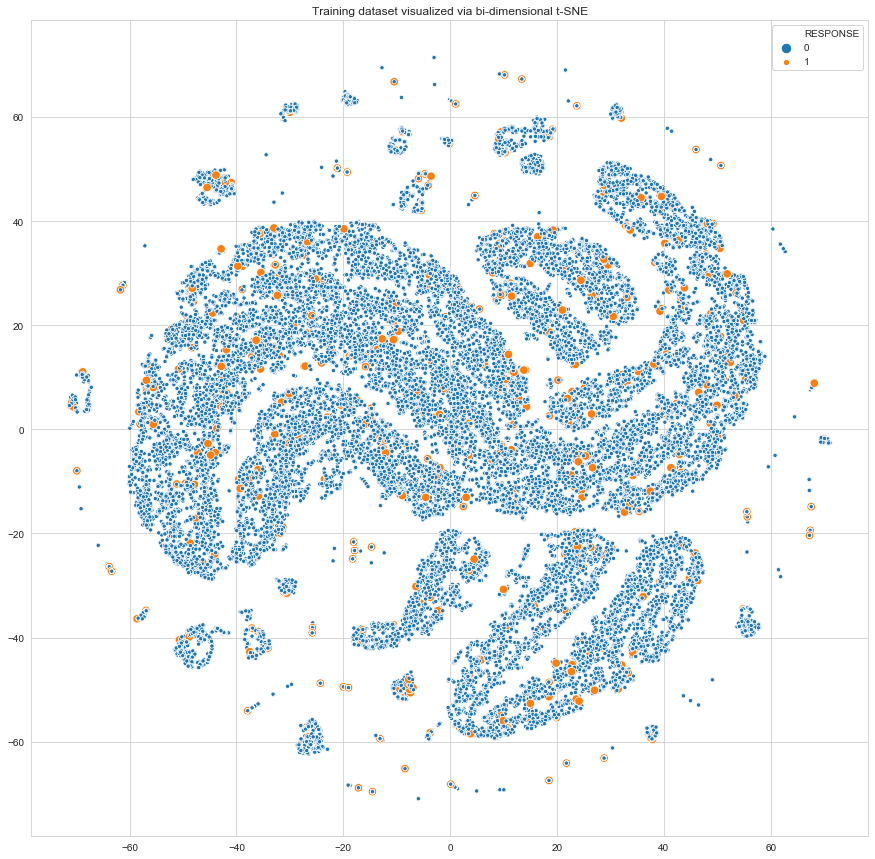

In [122]:
sns.set_style('whitegrid')
plt.figure(figsize=(15, 15))
sns.scatterplot(x=tsne[:, 0], y=tsne[:, 1], hue=y_train, size=1-y_train)
plt.title('Training dataset visualized via bi-dimensional t-SNE')
plt.show()

# 3. Benchmark Model

In [157]:
log_train = pd.read_csv('./data/PreprocessedMailoutTrain.csv')
log_y_train = log_train.RESPONSE
log_train = log_train.drop(['RESPONSE'], axis=1)

In [158]:
log_train, log_cv, log_y_train, log_y_cv = train_test_split(train, y_train, test_size=0.25, stratify=y_train, random_state=321)

## 3.2. Fitting the model

In [160]:
baseline_model = LogisticRegression(penalty='none', solver='sag')
baseline_model.fit(log_train, log_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='sag', tol=0.0001, verbose=0,
                   warm_start=False)

In [164]:
benchmark_proba = baseline_model.predict_proba(log_cv)[:, 1]
print(roc_auc_score(log_y_cv, benchmark_proba))

0.5437781387858787


# 4. CatBoost Classification

## 4.1. Bayesian hyperparameter tuning with hyperopt

In [19]:
X_train_hyperopt, X_test_hyperopt, y_train_hyperopt, y_test_hyperopt = train_test_split(train, y_train, train_size = 0.75, random_state=42,
                                                                                        stratify = y_train)

print(X_train_hyperopt.shape)
print(y_train_hyperopt.shape)
print(X_test_hyperopt.shape)
print(y_test_hyperopt.shape)

(32221, 367)
(32221,)
(10741, 367)
(10741,)


The hyperopt package requires the loss function to be a minimization objective. Given that we want our ROC-AUC to be as high as possible, we can use its negative value as a minimization objective. 

In [20]:
def objective(params):
    print('Fitting CatBoost model with {} iterations and depth {}.'.format(params['param']['iterations'], params['param']['depth']))
    model = params['model'](**params['param'])
    model.fit(X_train_hyperopt, np.ravel(y_train_hyperopt), eval_set=(X_test_hyperopt, y_test_hyperopt), cat_features=categ_vars, early_stopping_rounds=60)
       
    pred_test = pd.DataFrame(model.predict_proba(X_test_hyperopt)[:, 1], columns=['pred'])
    best_score = roc_auc_score(y_true=y_test_hyperopt, y_score=pred_test)
    loss = -np.round((best_score), decimals = 6)
    hyperparameter_set[loss] = params
    
    return {'loss': loss, 'params': params, 'status': STATUS_OK}

We will also define a function that creates a back-up for the hyperopt trials after a set number of Bayesian search iterations. This is helpful for situations when the kernel crashes, or when more iterations are required at a later point in time. Given the at least partially deterministic nature of the Bayesian search process, this back-up will essentially act as a warm start. The back-up file, called "my_optimization_catboost.hyperopt" is saved in the working directory.

In [21]:
def run_trials(pickling_freq, initial_max_trials):
    max_trials = initial_max_trials
    warnings.warn("UserWarning", UserWarning) #disable UserWarnings while running hyperopt in the run_trials() function
  
    # The CatBoost parameter space to test
    CatBoost_params = {'model': CatBoostClassifier,
                       'param': {
                           'iterations': hp.choice('iterations', np.arange(100, 3000, 10, dtype = int)),
                           'depth': hp.choice('depth', np.arange(1, 11, 1, dtype = int)),
                           'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(0.2)),
                           'class_weights': [1, hp.uniform('class_weight', 1, 100)],
                           'border_count': hp.choice('border_count', np.arange(1, 255, 1, dtype = int)),
                           'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0, 100),
                           'eval_metric': 'AUC',
                           'logging_level': 'Silent',
                           'task_type': 'GPU'
                       }
                      } 
       
    try:  # try to load an already saved trials object, and increase the max
        trials = pickle.load(open("./my_optimization_catboost.hyperopt", "rb"))
        max_trials = len(trials.trials) + pickling_freq
        print("Rerunning from {} trials to {} (+{}) trials".format(len(trials.trials), max_trials, pickling_freq))
    except:  # if no existing object was found, create a new one
        trials = Trials()
 
    fmin(fn=objective, space=CatBoost_params, algo=tpe.suggest, max_evals=max_trials, trials=trials)
    best = hyperparameter_set[sorted(hyperparameter_set)[0]]
    print("The best model so far:", best, "\n")
    
    # Saving the Trials object once optimization is finished
    pickle.dump(trials, open("./my_optimization_catboost.hyperopt", "wb"))
    print("Saved Trials! \n")  

In [27]:
hyperparameter_set = {}
i = 0  
save_frequency = 30   # How often do you want your trials to be backed-up?
initial_trials = 10    # How many Hyperopt iterations do you want to run before the first back up, if none exists?
hyperopt_iters = 290   # How many optimization iterations do you want to run (on top of the backe-up ones, if they exist)? Will be a multiple of save_frequency

while i <= (hyperopt_iters/save_frequency):
    i += 1
    with warnings.catch_warnings():
        warnings.simplefilter("ignore") 
        run_trials(pickling_freq = save_frequency, initial_max_trials = initial_trials)

Fitting CatBoost model with 340 iterations and depth 6.                                                                
Fitting CatBoost model with 160 iterations and depth 5.                                                                
Fitting CatBoost model with 2300 iterations and depth 4.                                                               
Fitting CatBoost model with 1830 iterations and depth 10.                                                              
Fitting CatBoost model with 2640 iterations and depth 1.                                                               
Fitting CatBoost model with 2970 iterations and depth 5.                                                               
Fitting CatBoost model with 1840 iterations and depth 4.                                                               
Fitting CatBoost model with 2860 iterations and depth 9.                                                               
Fitting CatBoost model with 1410 iterati

## 4.2. k-fold cross validation

In [22]:
def classification_kfold(X_train, y_train, X_test, model, nfold, random_state=707, categorical_features=categ_vars):
    skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=random_state)
    oof_pred = np.zeros(len(train))
    label = np.zeros(len(train))
    test_preds = np.zeros(len(X_test))
    
    i = 1
    for train_index, valid_index in skf.split(X=X_train, y=y_train):
        print('Fold {}'.format(i))
        
        train_cv = X_train.iloc[train_index, :]
        y_train_cv = y_train.iloc[train_index]
    
        valid_cv = X_train.iloc[valid_index, :]
        y_valid_cv = y_train.iloc[valid_index]
    
        model.fit(train_cv, y_train_cv, cat_features=categorical_features,
                  eval_set=(valid_cv, y_valid_cv), early_stopping_rounds=60)
        
          
        oof_pred[valid_index] = model.predict_proba(X_train.iloc[valid_index, :])[:, 1]  
        label[valid_index] = y_train.iloc[valid_index].values.reshape(-1)
        
        print("Out-of-fold ROC-AUC score: {:<0.4f}"
              .format(roc_auc_score(y_true=label[valid_index], y_score=oof_pred[valid_index])))
        
        # Based on the ROC curve, let us determine the optimal probability threshold
        #  for separating the two response classes
        fpr, tpr, thresholds = roc_curve(y_true=label[valid_index], y_score=oof_pred[valid_index])
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]
        class_pred = np.where(oof_pred[valid_index] >= optimal_threshold, 1, 0)
        print("Out-of-fold precision score: {:<0.4f}"
              .format(precision_score(y_true=label[valid_index], y_pred=class_pred)))
        print("Out-of-fold recall score: {:<0.4f} \n"
              .format(recall_score(y_true=label[valid_index], y_pred=class_pred)))
        
        
        test_preds = model.predict_proba(X_test)[:, 1] / nfold    
        i += 1
        
    print("Final cross-validation ROC-AUC score: {:<0.4f}".format(roc_auc_score(y_true=label, y_score=oof_pred)))
    
    # Precision and recall require class (not probability) predictions
    fpr, tpr, thresholds = roc_curve(y_true=label, y_score=oof_pred)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    class_pred = np.where(oof_pred >= optimal_threshold, 1, 0)
    print("Final cross-validation precision score: {:<0.4f}"
          .format(precision_score(y_true=label, y_pred=class_pred)))
    print("Final cross-validation recall score: {:<0.4f}"
          .format(recall_score(y_true=label, y_pred=class_pred)))
        
    return test_preds, model

In [9]:
best = hyperparameter_set[sorted(hyperparameter_set)[0]]
model = CatBoostClassifier(**best['param'])

In [23]:
%%time
kaggle_preds, model = classification_kfold(X_train=train, y_train=y_train, X_test=test, model=model, nfold=7)

Fold 1
Out-of-fold ROC-AUC score: 0.8105
Out-of-fold precision score: 0.0285
Out-of-fold recall score: 0.9211 

Fold 2
Out-of-fold ROC-AUC score: 0.7632
Out-of-fold precision score: 0.0339
Out-of-fold recall score: 0.6842 

Fold 3
Out-of-fold ROC-AUC score: 0.7420
Out-of-fold precision score: 0.0334
Out-of-fold recall score: 0.6711 

Fold 4
Out-of-fold ROC-AUC score: 0.7851
Out-of-fold precision score: 0.0311
Out-of-fold recall score: 0.8421 

Fold 5
Out-of-fold ROC-AUC score: 0.7941
Out-of-fold precision score: 0.0303
Out-of-fold recall score: 0.8421 

Fold 6
Out-of-fold ROC-AUC score: 0.7451
Out-of-fold precision score: 0.0247
Out-of-fold recall score: 0.8421 

Fold 7
Out-of-fold ROC-AUC score: 0.7855
Out-of-fold precision score: 0.0386
Out-of-fold recall score: 0.7500 

Final cross-validation ROC-AUC score: 0.7292
Final cross-validation precision score: 0.0245
Final cross-validation recall score: 0.7237
Wall time: 4min 51s


### Kaggle submission file

In [117]:
pd.concat([pd.DataFrame(lnr_test, columns=['LNR']),
           pd.DataFrame(kaggle_preds, columns=['RESPONSE'])], axis=1).to_csv('./kaggle/ArvatoCapstoneKaggleSubmission15.csv', index=False)

## 4.3. Permutation importance

It can sometimes be the case that some features are actually decreasing the performance of a model by introducing noise. An effective indicator for identifying these features is called permutation importance. "Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature’s values, which breaks the relationship between the feature and the true outcome." ([Chapter 5.5 Permutation Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html), Interpretable Machine Learning, Christoph Molnar).

Based on this definition, we are dealing with a feature of **positive** importance whenever permuting a feature leads to a **decrease** in ROC-AUC. Conversely, if mixing up a feature leads to an **increase** in our metric, we are actually better off not including that predictor in our model. In order to improve our model, we will re-fit the model with only positive-importance features.

In [24]:
def permutation_importance_auc(X, y, model, plotsize=(15, 70)):
    proba_pred = pd.DataFrame(model.predict_proba(X)[:, 1], index=X.index.values)
    baseline = roc_auc_score(y_true=y, y_score=proba_pred)
    importance_list = []
    
    for c in list(X):
        save = X[[c]].copy()
        X[[c]] = np.random.permutation(X[[c]])
    
        proba_pred = pd.DataFrame(model.predict_proba(X)[:, 1], index=X.index.values)
        auc = roc_auc_score(y_true=y, y_score=proba_pred)
        
        X[[c]] = save.copy()
        importance_list.append(baseline - auc)
        
    importance_df = pd.DataFrame()
    importance_df["feature"] = list(X)
    importance_df["permutation_importance"] = importance_list
    
    plt.figure(figsize=plotsize)
    sns.barplot(x='permutation_importance', y='feature',
                data=importance_df.sort_values('permutation_importance', ascending = False))
    plt.title('Feature importance by permutation', fontweight = 'bold', fontsize = 14)
    plt.xlabel('Decrease in AUC after permutation')
    plt.show()
        
    return importance_df

In [124]:
sns.set_style('whitegrid')

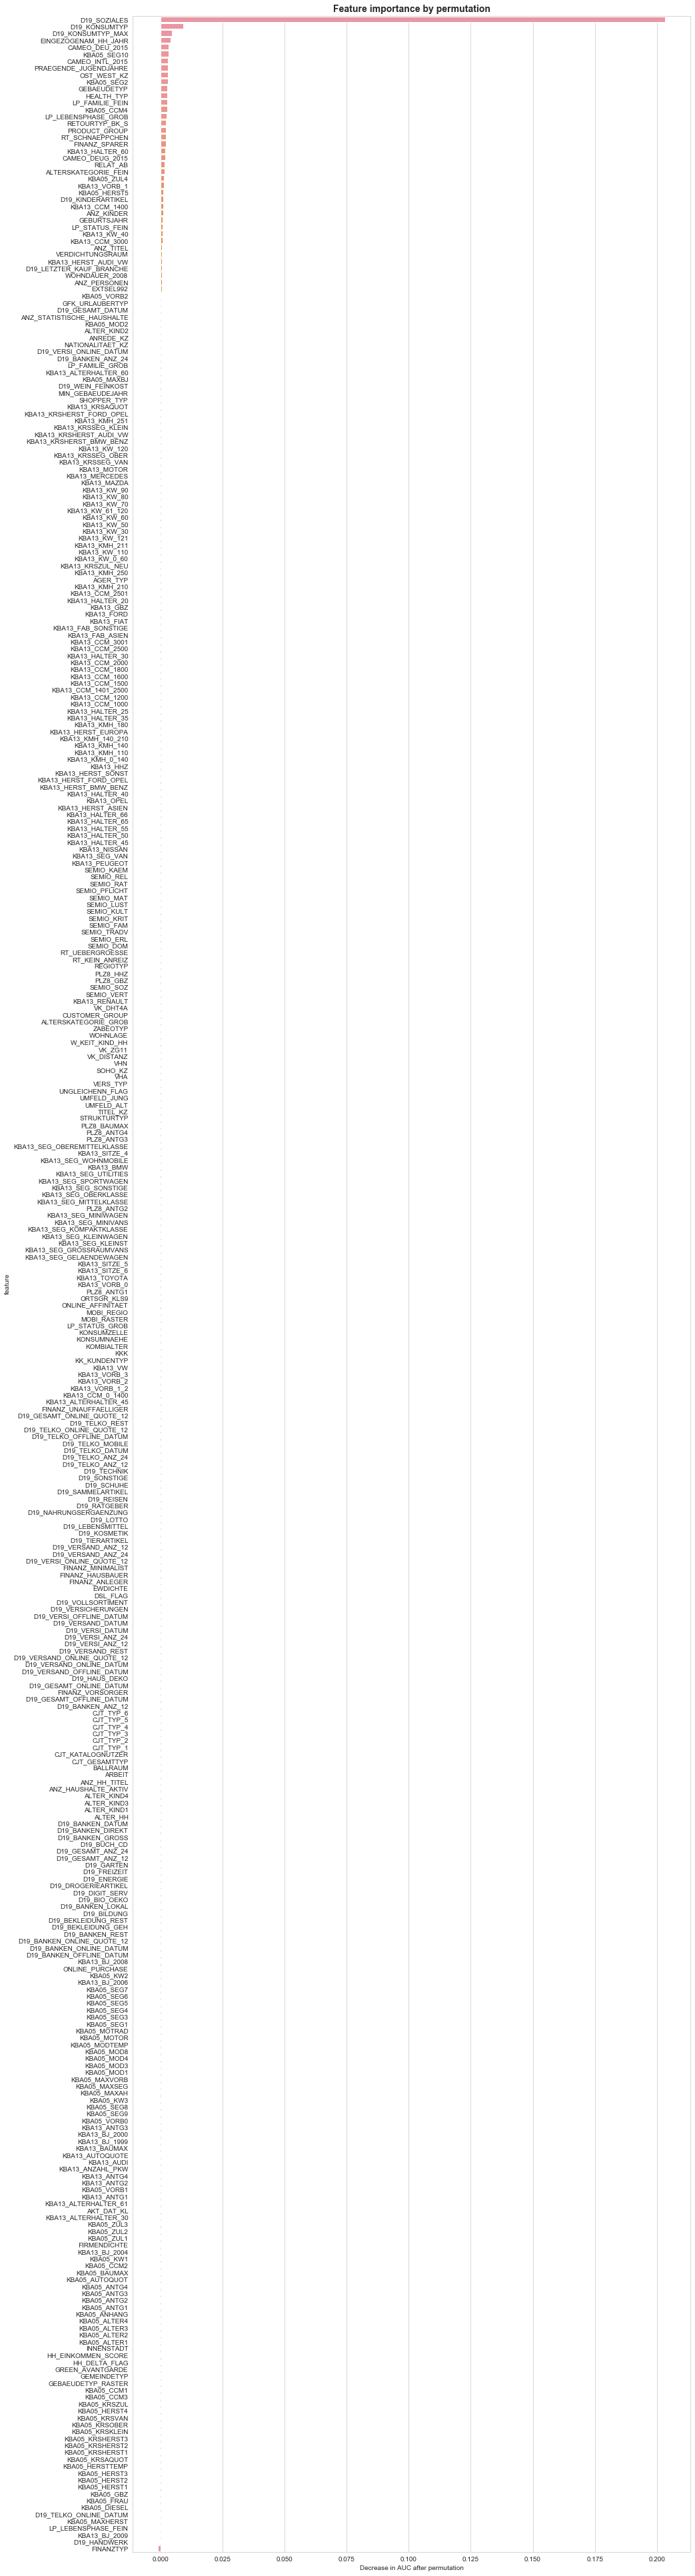

Wall time: 2min 1s


In [125]:
%%time
importance_df = permutation_importance_auc(train, y_train, model, plotsize=(15, 70))

In [166]:
importance_df.loc[importance_df.permutation_importance < 0, 'feature'].values

array(['D19_HANDWERK', 'D19_TELKO_ONLINE_DATUM', 'FINANZTYP',
       'KBA05_MAXHERST', 'KBA13_BJ_2009', 'LP_LEBENSPHASE_FEIN'],
      dtype=object)

In [27]:
positive_features = importance_df.loc[importance_df.permutation_importance >= 0, 'feature']
positive_categorical = list(set(positive_features).intersection(categ_vars))

In [29]:
kaggle_preds, model_refined = classification_kfold(X_train=train.loc[:, positive_features], y_train=y_train,
                                                   X_test=test.loc[:, positive_features],
                                                   model=CatBoostClassifier(**best['param']),
                                                   nfold=7,
                                                   categorical_features=positive_categorical)

Fold 1
Out-of-fold ROC-AUC score: 0.8176
Out-of-fold precision score: 0.0442
Out-of-fold recall score: 0.7632 

Fold 2
Out-of-fold ROC-AUC score: 0.7623
Out-of-fold precision score: 0.0304
Out-of-fold recall score: 0.7500 

Fold 3
Out-of-fold ROC-AUC score: 0.7378
Out-of-fold precision score: 0.0330
Out-of-fold recall score: 0.6711 

Fold 4
Out-of-fold ROC-AUC score: 0.7866
Out-of-fold precision score: 0.0309
Out-of-fold recall score: 0.8421 

Fold 5
Out-of-fold ROC-AUC score: 0.7917
Out-of-fold precision score: 0.0262
Out-of-fold recall score: 0.8816 

Fold 6
Out-of-fold ROC-AUC score: 0.7478
Out-of-fold precision score: 0.0317
Out-of-fold recall score: 0.6842 

Fold 7
Out-of-fold ROC-AUC score: 0.7946
Out-of-fold precision score: 0.0382
Out-of-fold recall score: 0.7500 

Final cross-validation ROC-AUC score: 0.7583
Final cross-validation precision score: 0.0310
Final cross-validation recall score: 0.7462


Less variance in the model performance was achieved. Let's now fit the final model on a larger dataset.

In [32]:
train_final, val_final, y_train_final, y_val_final = train_test_split(train.loc[:, positive_features], y_train, test_size=0.2, stratify=y_train)

In [33]:
model_final = CatBoostClassifier(**best['param'])
model_final.fit(train_final, y_train_final, eval_set=(val_final, y_val_final), cat_features=positive_categorical, early_stopping_rounds=60)

# 5. ML Model Interpretation

## 5.1. Partial dependence plots

top 10 numeric features

In [106]:
top10features = importance_df.sort_values('permutation_importance', ascending=False).iloc[0:10, 0]

In [114]:
top10features

68             D19_SOZIALES
57        D19_KONSUMTYP_MAX
96     EINGEZOGENAM_HH_JAHR
328         RT_SCHNAEPPCHEN
113              HEALTH_TYP
107             GEBAEUDETYP
315             OST_WEST_KZ
166             KBA05_SEG10
7      ALTERSKATEGORIE_FEIN
303         LP_FAMILIE_FEIN
Name: feature, dtype: object

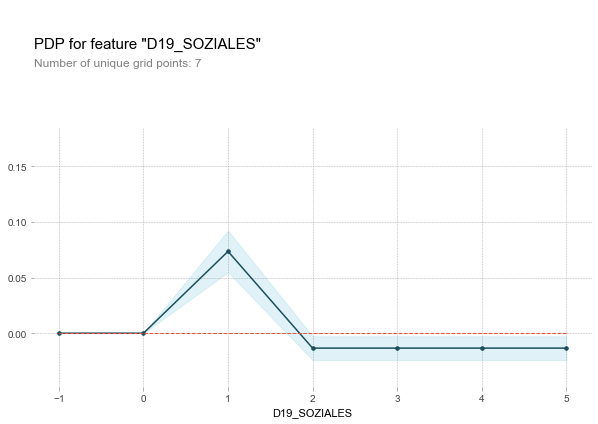

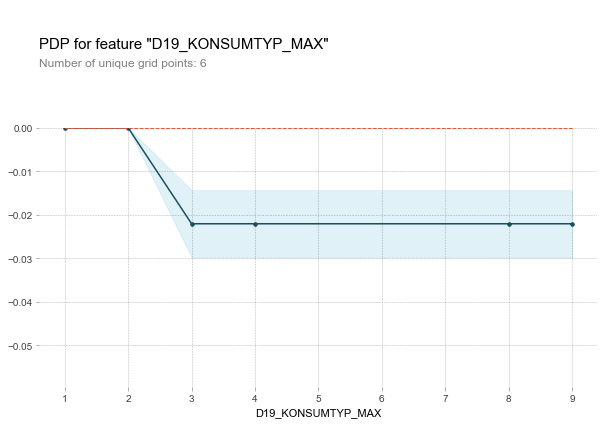

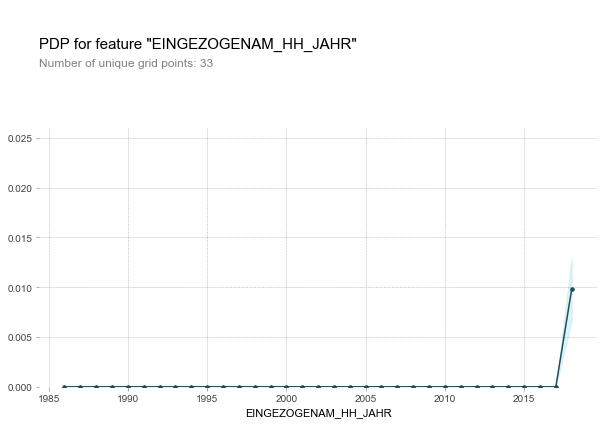

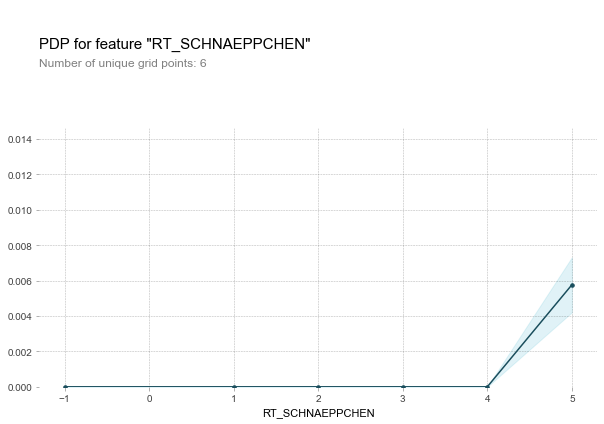

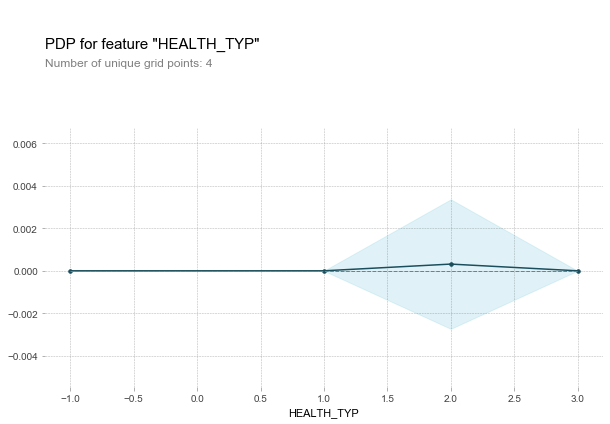

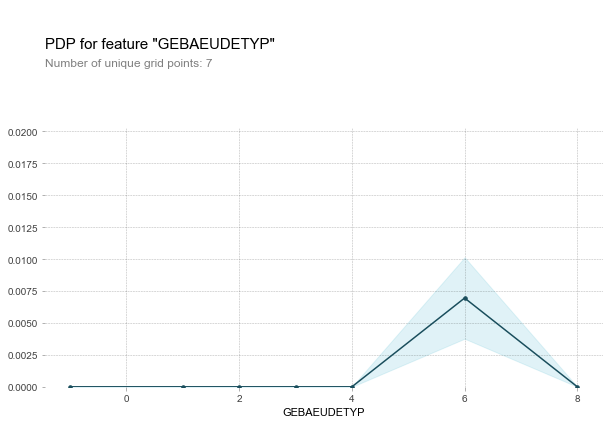

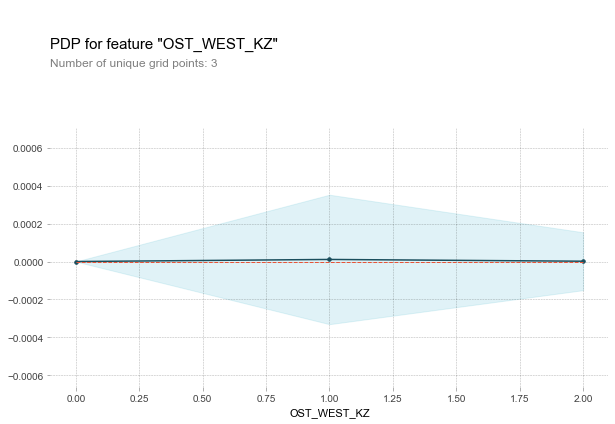

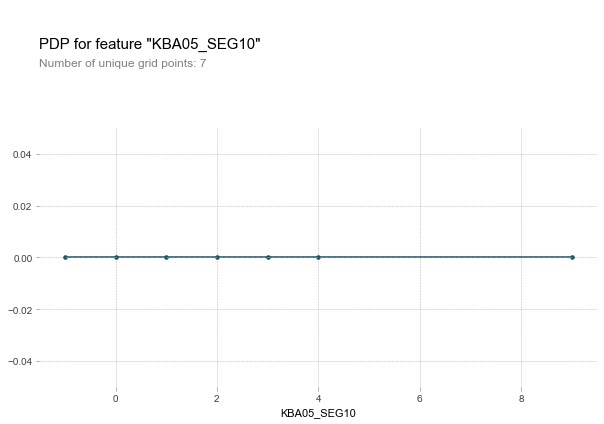

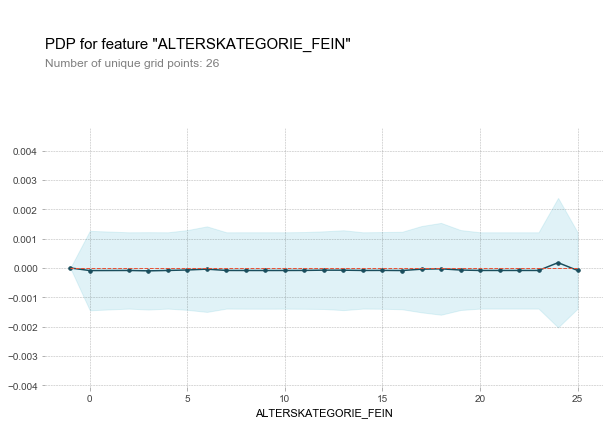

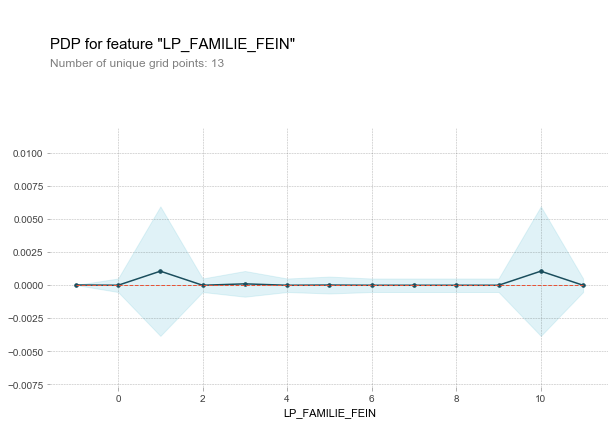

In [116]:
df = train_final.copy()
for f in top10features:
    if f == 'EINGEZOGENAM_HH_JAHR':
        pdp_response = pdp.pdp_isolate(model=model_final, dataset=df, model_features=df.columns, feature=f, grid_type='equal', cust_grid_points=np.arange(1986, 2019, 1))
    else:
        pdp_response = pdp.pdp_isolate(model=model_final, dataset=df, model_features=df.columns, feature=f, grid_type='equal', cust_grid_points=np.sort(df[f].unique()))
    
    pdp.pdp_plot(pdp_response, f, figsize=(10, 7))
    plt.savefig('PDP_{}.png'.format(f))

## 5.2. Shap values

In [70]:
ml_explain_set = Pool(train_final, cat_features=positive_categorical)
shap_values = model_final.get_feature_importance(ml_explain_set, type="ShapValues")

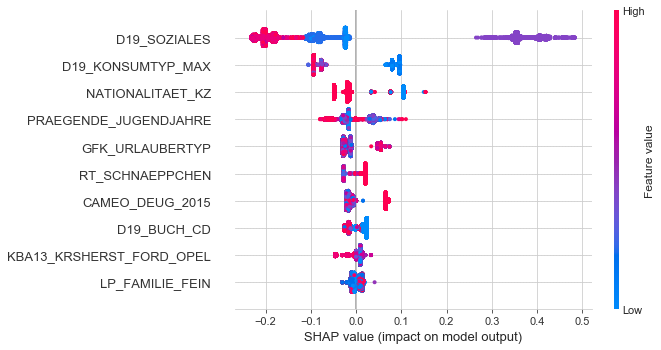

In [127]:
shap.summary_plot(shap_values[:, :-1], train_final, max_display=10)